# 数据集定义与加载


深度学习模型需要大量的数据来完成训练和评估，这些数据样本可能是图片（image）、文本（txt）、语音（audio）等多种类型，而模型训练过程实际是数学计算过程，因此数据样本在送入模型前需要经过一系列处理，如划分数据集、变换数据形状（shape）、制作数据迭代读取器以备分批训练等。

归纳起来主要需定义如下几个类：

* **定义数据集类**：将磁盘中保存的原始图片、文字等样本和对应的标签映射到 Dataset，方便后续通过索引（index）读取数据，在 Dataset 中还可以进行一些数据变换、数据增广等预处理操作。在飞桨框架中推荐使用 [paddle.io.Dataset](../../api/paddle/io/Dataset_cn.html#dataset) 自定义数据集，另外在 [paddle.vision.datasets](../../api/paddle/vision/Overview_cn.html#api) 和 [paddle.text](../../api/paddle/text/Overview_cn.html#api) 目录下飞桨内置了一些经典数据集方便直接调用。


* **定义数据读取器类**：自动将数据集的样本进行分批（batch）、乱序（shuffle）等操作，方便训练时迭代读取，同时还支持多进程异步读取功能可加快数据读取速度。在飞桨框架中可使用 [paddle.io.DataLoader](../../api/paddle/io/DataLoader_cn.html#dataloader) 迭代读取数据集。

本文以图像数据集为例介绍，文本数据集可参考 [NLP实践](../../practices/nlp/index_cn.html)。

## 一、定义数据集

### 1.1 直接加载内置数据集

飞桨框架在 [paddle.vision.datasets](../../api/paddle/vision/Overview_cn.html#api) 和 [paddle.text](../..//api/paddle/text/Overview_cn.html#api) 目录下内置了一些经典数据集可直接调用，如 CV 领域的 MNIST、Cifar10、VOC2012，NLP 领域的 Movielens、Imdb 等，通过以下代码可查看飞桨框架中的内置数据集。

In [1]:
import paddle
print('计算机视觉（CV）相关数据集：', paddle.vision.datasets.__all__)
print('自然语言处理（NLP）相关数据集：', paddle.text.__all__)

计算机视觉（CV）相关数据集： ['DatasetFolder', 'ImageFolder', 'MNIST', 'FashionMNIST', 'Flowers', 'Cifar10', 'Cifar100', 'VOC2012']
自然语言处理（NLP）相关数据集： ['Conll05st', 'Imdb', 'Imikolov', 'Movielens', 'UCIHousing', 'WMT14', 'WMT16', 'ViterbiDecoder', 'viterbi_decode']


以 [MNIST](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/datasets/MNIST_cn.html) 数据集为例，加载内置数据集的代码示例如下所示。

In [2]:
from paddle.vision.transforms import Normalize

transform = Normalize(mean=[127.5], std=[127.5], data_format='CHW')
# 下载数据集并初始化DataSet
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)
print('train images: ',len(train_dataset),', test images: ',len(test_dataset))

train images:  60000 , test images:  10000


内置的 [MNIST](../../api/paddle/vision/datasets/MNIST_cn.html) 数据集已经划分好了训练集和测试集，通过 `mode` 字段传入 `'train'` 或 `'test'` 来区分。另外可通过 `transform` 字段传入一些对图像进行变换的操作，飞桨在 [paddle.vision.transforms](../..api/paddle/vision/Overview_cn.html#about-transforms) 里提供了一些常用的图像变换操作，如对图像进行中心裁剪、水平翻转图像和对图像进行归一化等。这里在初始化MNIST数据集时传入了 `Normalize` 变换对图像进行归一化，对图像进行归一化可以加快模型的收敛速度。

完成数据集初始化之后，可以使用下面的代码直接对数据集进行迭代。

shape of image:  (1, 28, 28)


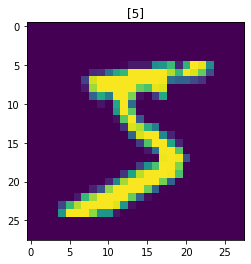

In [9]:
from matplotlib import pyplot as plt

for data in train_dataset:
    image, label = data
    print('shape of image: ',image.shape)
    plt.title(str(label))
    plt.imshow(image[0])    
    break

### 1.2 使用 paddle.io.Dataset 自定义数据集

在实际的场景中，需要使用自有的数据来定义数据集，这时可以通过飞桨提供的 `paddle.io.Dataset` 基类来实现自定义数据集。

可构建一个子类继承自 `paddle.io.Dataset` ，并且实现下面的三个函数：

1. `__init__`：完成一些数据集初始化操作，如指定数据和标签文件的存储路径、定义数据集大小等。
2. `__getitem__`：定义指定索引（index）时如何获取数据，并且在此函数中可定义一些数据预处理工作，如读取图像、对图像进行数据增强、制作标签等操作，最终返回处理好的单条数据（训练数据、对应的标签）。
3. `__len__`：返回数据集的样本总数。



In [6]:
# 下载 MNIST 数据集并解压
! wget https://paddle-imagenet-models-name.bj.bcebos.com/data/mnist.tar
! tar -xf mnist.tar

--2022-01-12 14:38:05--  https://paddle-imagenet-models-name.bj.bcebos.com/data/mnist.tar
正在解析主机 paddle-imagenet-models-name.bj.bcebos.com (paddle-imagenet-models-name.bj.bcebos.com)... 111.206.210.93, 111.206.210.81
正在连接 paddle-imagenet-models-name.bj.bcebos.com (paddle-imagenet-models-name.bj.bcebos.com)|111.206.210.93|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：104252416 (99M) [application/x-tar]
正在保存至: “mnist.tar”

mnist.tar           100%[===================>]  99.42M  2.29MB/s  用时 45s       

2022-01-12 14:38:51 (2.21 MB/s) - 已保存 “mnist.tar” [104252416/104252416])



In [35]:
import os
import cv2
import numpy as np
from paddle.io import Dataset

class MyDataset(Dataset):
    """
    步骤一：继承 paddle.io.Dataset 类
    """
    def __init__(self, data_dir, label_path, transform=None):
        """
        步骤二：实现 __init__ 函数，定义数据集大小
        """
        super(MyDataset, self).__init__()
        self.data_list = []
        with open(label_path,encoding='utf-8') as f:
            for line in f.readlines():
                image_path, label = line.strip().split('\t')
                image_path = os.path.join(data_dir, image_path)
                self.data_list.append([image_path, label])
        self.transform = transform

    def __getitem__(self, index):
        """
        步骤三：实现 __getitem__ 函数，定义指定 index 时如何获取数据，并返回单条数据（训练数据、对应的标签）
        """
        # 根据索引，从列表中取出一个
        image_path, label = self.data_list[index]
        # 读取灰度图
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # 图像数据格式转换为 float32，此步骤为必须
        image = image.astype('float32')
        if self.transform is not None:
            image = self.transform(image)
        label = int(label)
        return image, label

    def __len__(self):
        """
        步骤四：实现 __len__ 函数，返回数据集的样本总数
        """
        return len(self.data_list)

在上面的代码中，定义了一个自定义的数据集类MyDataset，MyDataset继承自Dataset，并且实现了`__init__`,`__getitem__`和`__len__`三个方法。在`__init__`方法中完成了对标注文件的读取和解析，并且将所有的图像路径和对应的Label存放到一个列表中，在`__getitem__`方法中完成了图像的读取和预处理以及Label格式的转换，在`__len__`方法中返回`__init__`方法中初始化好的列表长度。

和内置数据集类似，可以使用下面的代码直接对自定义数据集进行迭代。

shape of image:  (1, 28, 28)


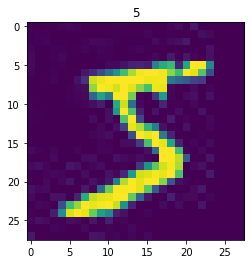

In [33]:
custom_dataset = MyDataset('mnist/train','mnist/train/label.txt', transform)

for data in custom_dataset:
    image, label = data
    print('shape of image: ',image.shape)
    plt.title(str(label))
    plt.imshow(image[0])    
    break

## 二、使用 paddle.io.DataLoader 定义数据读取器


通过前面介绍的直接迭代读取 DataSet 的方式虽然可实现对数据集的访问，但是这种访问方式只能单线程进行并且还需要手动分批次（batch）。在飞桨框架中，推荐使用 [paddle.io.DataLoader](../../api/paddle/io/DataLoader_cn.html#dataloader) API 对数据集进行多进程的读取，并且可自动完成划分 batch 的工作，开发者只需要进行数据处理模块的编写。

shape of image:  [64, 1, 28, 28] shape of label:  [64]


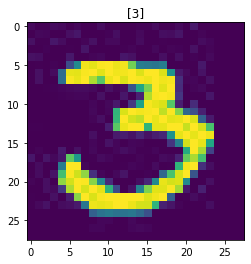

In [34]:
# 定义并初始化数据读取器
train_loader = paddle.io.DataLoader(custom_dataset, batch_size=64, shuffle=True, num_workers=1)

# 调用 DataLoader 迭代读取数据
for batch_id, data in enumerate(train_loader()):
    images, labels = data
    print('shape of image: ',images.shape, 'shape of label: ', labels.shape)
    plt.title(str(labels[0].numpy()))
    plt.imshow(images[0][0])    
    break

通过上述方法，初始化了一个数据读取器 `train_loader`，用于加载训练数据集 `train_dataset`。在数据读取器中常见的几个配置如下：

* **训练样本乱序**：通过设置 `shuffle=True` ，可以在取数据前打乱样本顺序。
* **生成批次数据**：通过 `batch_size` 设置生成批次数据的批大小，示例中设置为 64。
* **同步/异步读取数据**：通过设置 `num_workers` 来设置加载数据的子进程个数，num_workers的值设为大于0时，即开启多进程方式异步加载数据，可提升数据读取速度。

## 三、总结

本节中介绍了Paddle中的数据送入模型之前的处理流程：数据集+数据读取器。进一步介绍了如何使用内置数据集和自定义数据集，在数据集中，本节仅对数据集进行了归一化，如需了解更多数据增强或数据处理操作，可以参考[数据预处理](03_data_preprocessing_cn.html)